### Preparación y visualización temporal de la potencia eólica

El código construye una serie temporal diaria de la potencia eólica instalada, eliminando el 29 de febrero para evitar discontinuidades temporales, y representa su evolución en el tiempo mediante una gráfica de líneas.  


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1825 entries, 0 to 1824
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Year                           1825 non-null   int64         
 1   Month                          1825 non-null   int64         
 2   Day                            1825 non-null   int64         
 3   DayOfYear                      1825 non-null   int64         
 4   Demanda_GWh                    1825 non-null   float64       
 5   Gen_Eolica_GWh                 1825 non-null   float64       
 6   Gen_Solar_GWh                  1825 non-null   float64       
 7   Pot_Eolica_GW                  1825 non-null   float64       
 8   Pot_Solar_GW                   1825 non-null   float64       
 9   Price_Elec_EUR_MWh             1825 non-null   float64       
 10  Temp_min_C_Nat                 1825 non-null   float64       
 11  Temp_max_C_Nat   

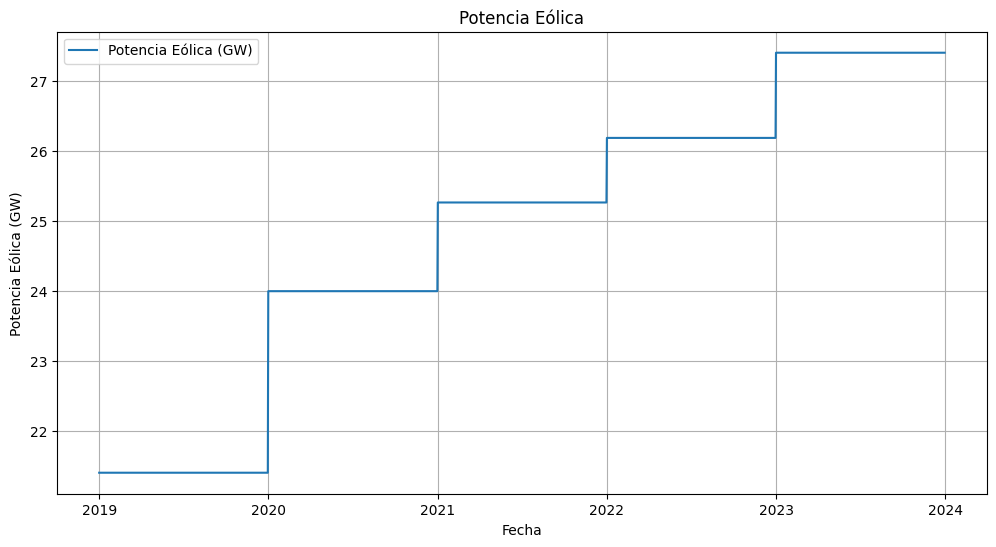

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar datos
df = pd.read_csv("../../SET_INPUTS_BASE_0.csv")

# Creamos las columnas Year, Month y Day a partir de la columna 'Date'
df["Date"] = pd.to_datetime(df[["Year", "Month", "Day"]])

# Eliminamos 29 de febrero en años bisiestos
df = df[~((df["Date"].dt.month == 2) & (df["Date"].dt.day == 29))].reset_index(drop=True)
df["Year"].value_counts().sort_index()

df.info()


plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Pot_Eolica_GW'], label='Potencia Eólica (GW)')
plt.xlabel('Fecha')
plt.ylabel('Potencia Eólica (GW)')
plt.title('Potencia Eólica')
plt.legend()
plt.grid()
plt.show()

### Proyección lineal de la potencia eólica y desagregación diaria (PNIEC)

Este código construye el histórico anual de potencia eólica instalada, proyecta los valores para 2024–2030 mediante un **modelo lineal** basado en los objetivos del PNIEC y genera una serie diaria con valor constante por año (eliminando el 29 de febrero). El resultado se exporta a un fichero CSV para su uso en modelos posteriores.

In [8]:
# Datos históricos
pot_eolica_anual = (
    df.groupby("Year", as_index=False)["Pot_Eolica_GW"]
      .first().round(7)
)

# Parámetros PNIEC
year_start = 2023
year_end = 2030
pot_start = 27.4014825
pot_end = 62.0000000

incremento = (pot_end - pot_start) / (year_end - year_start)

# Proyección 2024–2030
proy = []
for y in range(2024, 2031):
    valor = pot_start + incremento * (y - year_start)
    proy.append({
        "Year": y,
        "Pot_Eolica_GW": round(valor, 7)
    })

df_proy = pd.DataFrame(proy)

# Uniión de histórico + proyección
df_final = pd.concat([pot_eolica_anual, df_proy], ignore_index=True)

print(df_final)

# Generación datos diarios 2024–2030
rows = []

for _, row in df_final.iterrows():
    year = int(row["Year"])
    pot  = row["Pot_Eolica_GW"]

    if 2024 <= year <= 2030:
        fechas = pd.date_range(
            start=f"{year}-01-01",
            end=f"{year}-12-31",
            freq="D"
        )
        # Eliminamos 29 de febrero
        fechas = fechas[~((fechas.month == 2) & (fechas.day == 29))]
        
        for f in fechas:
            rows.append({
                "Year": f.year,
                "Month": f.month,
                "Day": f.day,
                "Pot_Eolica_GW": pot
            })

df_diario = pd.DataFrame(rows)

# Exportamos los resultado a CSV
df_diario.to_csv("pot_eolica_diaria_2024_2030.csv", index=False)

df_diario.head()


    Year  Pot_Eolica_GW
0   2019      21.396928
1   2020      23.992577
2   2021      25.260458
3   2022      26.183592
4   2023      27.401483
5   2024      32.344128
6   2025      37.286773
7   2026      42.229419
8   2027      47.172064
9   2028      52.114709
10  2029      57.057355
11  2030      62.000000


,Year,Month,Day,Pot_Eolica_GW
0,2024,1,1,32.344128
1,2024,1,2,32.344128
2,2024,1,3,32.344128
3,2024,1,4,32.344128
4,2024,1,5,32.344128
